<a href="https://colab.research.google.com/github/malcolmfisher103/Bioinformatic-Scripts/blob/main/Isoform_expression_chart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Specify Genes
genes_to_plot = ["tbxt.2"] # @param {type:"raw"}
# multiple selected genes should be like ["nadsyn1", "wnt7a", "shh"]

In [2]:
# @title Imports
import pandas as pd
import requests
import gzip
import io
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
from scipy.interpolate import interp1d

In [3]:
# @title Load data
def load_tpm_matrix():
    return pd.read_csv(
        'https://bigfrog.xenbase.org/xenbase/genomics/GEO/GSE65785/XENTR_10.0/RNA-Seq/ExpressionFiles/Isoforms_TPM_Matrix.txt',
        sep='\t',
        index_col=0
    )

def load_gene_info():
    return pd.read_csv('https://xenbase-bio1.ucalgary.ca/cgi-bin/reports/models_gene_info.cgi', sep='\t', index_col=None)

def load_gsm_sample_mapping():
    return pd.read_csv(
        'https://bigfrog.xenbase.org/xenbase/genomics/GEO/GSE65785/XENTR_10.0/RNA-Seq/gsm_to_track.txt',
        sep='\t'
    )

def load_gsm_srr_mapping():
    return pd.read_csv(
        'https://download.xenbase.org/xenbase/GenePageReports/geo_srr_metadata_chd.txt',
        sep='\t'
    )

def load_mrna_model_mapping():
    # URL of the GFF3 file
    url = 'https://download.xenbase.org/xenbase/Genomics/JGI/Xentr10.0/XENTR_10.0_Xenbase.gff3.gz'

    # Download the file
    response = requests.get(url)
    response.raise_for_status()

    # Unzip the file
    with gzip.GzipFile(fileobj=io.BytesIO(response.content)) as f:
        lines = f.readlines()

    # Parse the GFF3 file
    data = []
    for line in lines:
        line = line.decode('utf-8')
        if line.startswith('#'):
            continue
        fields = line.strip().split('\t')
        if fields[2] == 'mRNA':
            attributes = fields[8]
            attr_dict = dict(item.split('=') for item in attributes.split(';'))
            mRNA_model = attr_dict.get('ID', '')
            RefSeq = attr_dict.get('Name', '')
            data.append([mRNA_model, RefSeq])

    # Create a DataFrame
    df = pd.DataFrame(data, columns=['mRNA_model', 'RefSeq'])

    return df

def create_gsm_to_srr_mapping(gsm_srr_mapping):
    return gsm_srr_mapping[['SRR', 'GSM']]



In [5]:
# @title substitute_gene_symbols
def substitute_gene_symbols(tpm_matrix, gene_info):
  gene_info.columns = gene_info.columns.str.upper()  # Normalize casing
  # Drop rows with null values in column 1 and column 2 in file 2
  gene_info = gene_info.dropna(subset=['GENE_SYMBOL', 'MODEL_NAME'])

# Drop duplicates in file 2 based on column 2
  gene_info = gene_info.drop_duplicates(subset=['MODEL_NAME'])

# Create a mapping dictionary from column 2 to column 1 in file 2
  mapping = dict(zip(gene_info['MODEL_NAME'], gene_info['GENE_SYMBOL']))

# Replace values in column 1 of file 1 with corresponding values from file 2
  tpm_matrix['Gene'] = tpm_matrix['Gene'].map(mapping).fillna(tpm_matrix['Gene'])

# Save the modified DataFrame back to file1.csv or use it as needed
#tpm_matrix.to_csv('modified_file1.csv', index=False)
  return tpm_matrix

In [6]:
# @title Process Data
def process_data(tpm_matrix, gene_info, gsm_sample_mapping, gsm_srr_mapping, mrna_model_mapping):
    # Extract isoform information before substituting gene symbols
    tpm_matrix[['Gene', 'Isoform']] = tpm_matrix.index.to_series().str.extract(r'([^<]+)<([^>]+)>')
    # Substitute gene symbols
    tpm_matrix = substitute_gene_symbols(tpm_matrix, gene_info)

    # Merge with mRNA model mapping to get RefSeq accessions
    tpm_matrix = tpm_matrix.merge(mrna_model_mapping, left_on='Isoform', right_on='mRNA_model', how='left')

    # Create GeneRefSeq column for plotting
    tpm_matrix['GeneRefSeq'] = tpm_matrix.apply(lambda x: f"{x['Gene']}<{x['RefSeq']}>", axis=1)

    # Convert SRR columns to sample names
    gsm_to_srr = create_gsm_to_srr_mapping(gsm_srr_mapping)
    gsm_mapping = gsm_sample_mapping[['Track Name', 'GSMs']]
    gsm_mapping.loc[:, 'GSMs'] = gsm_mapping['GSMs'].str.split(',')
    gsm_mapping = gsm_mapping.explode('GSMs')
    track_srr_mapping = pd.merge(left=gsm_mapping, right=gsm_srr_mapping, left_on='GSMs', right_on='GSM', validate="1:m")
    track_srr_mapping = track_srr_mapping.groupby('Track Name')['SRR'].apply(list).reset_index()
    track_srr_mapping_expanded = track_srr_mapping.explode('SRR')
    srr_columns = tpm_matrix.columns.intersection(track_srr_mapping_expanded['SRR'])
    srr_to_track = dict(zip(track_srr_mapping_expanded['SRR'], track_srr_mapping_expanded['Track Name']))
    tpm_matrix.rename(columns={col: srr_to_track.get(col, col) for col in srr_columns}, inplace=True)

    # Ensure only the SRR/sample name columns are used for melting and aggregation
    id_vars = ['Gene', 'Isoform', 'RefSeq', 'GeneRefSeq']
    value_vars = tpm_matrix.columns.difference(id_vars + ['mRNA_model', 'index'])

    # Reshape the data for plotting
    tpm_matrix_melted = pd.melt(tpm_matrix, id_vars=id_vars, value_vars=value_vars, var_name='Column')

    # Convert 'value' column to numeric, coercing errors to NaN
    tpm_matrix_melted['value'] = pd.to_numeric(tpm_matrix_melted['value'], errors='coerce')

    # Perform the aggregation
    try:
        tpm_matrix_grouped = tpm_matrix_melted.groupby(['GeneRefSeq', 'Column'])['value'].mean().unstack()
        tpm_matrix_grouped.reset_index(inplace=True)
    except Exception as e:
        print("Error during aggregation:", e)
        tpm_matrix_grouped = None  # Handle the error gracefully

    return tpm_matrix_grouped


In [7]:
# @title Main Function
def main():
    tpm_matrix = load_tpm_matrix()
    gene_info = load_gene_info()
    gsm_sample_mapping = load_gsm_sample_mapping()
    gsm_srr_mapping = load_gsm_srr_mapping()
    mrna_model_mapping = load_mrna_model_mapping()
    new_tpm_matrix = process_data(tpm_matrix, gene_info, gsm_sample_mapping, gsm_srr_mapping, mrna_model_mapping)
    new_tpm_matrix.to_csv('output.txt', sep='\t')

if __name__ == "__main__":
    main()



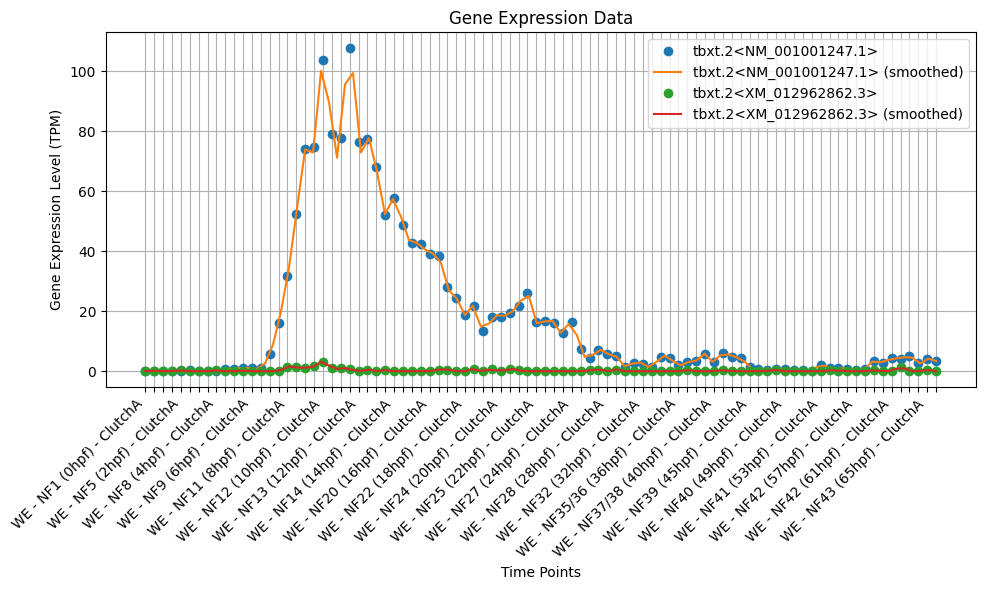

In [8]:
# @title Plot Graph
# Load DataFrame
new_tpm_matrix = pd.read_csv('output.txt', sep='\t', index_col=0)

df = pd.DataFrame(new_tpm_matrix)
df = df[df.columns.drop(list(df.filter(regex='ClutchA rd|ClutchB')))]
df = df[['GeneRefSeq','WE - NF1 (0hpf) - ClutchA','WE - NF1 (0.5hpf) - ClutchA','WE - NF2- (1hpf) - ClutchA','WE - NF3 (1.5hpf) - ClutchA','WE - NF5 (2hpf) - ClutchA','WE - NF6 (2.5hpf) - ClutchA','WE - NF7 (3hpf) - ClutchA','WE - NF7 (3.5hpf) - ClutchA','WE - NF8 (4hpf) - ClutchA','WE - NF9 (4.5hpf) - ClutchA','WE - NF9 (5hpf) - ClutchA','WE - NF9 (5.5hpf) - ClutchA','WE - NF9 (6hpf) - ClutchA','WE - NF10 (6.5hpf) - ClutchA','WE - NF10 (7hpf) - ClutchA','WE - NF10 (7.5hpf) - ClutchA','WE - NF11 (8hpf) - ClutchA','WE - NF12 (8.5hpf) - ClutchA','WE - NF12 (9hpf) - ClutchA','WE - NF12 (9.5hpf) - ClutchA','WE - NF12 (10hpf) - ClutchA','WE - NF12.5 (10.5hpf) - ClutchA','WE - NF12.5 (11hpf) - ClutchA','WE - NF12.5 (11.5hpf) - ClutchA','WE - NF13 (12hpf) - ClutchA','WE - NF13 (12.5hpf) - ClutchA','WE - NF13 (13hpf) - ClutchA','WE - NF14 (13.5hpf) - ClutchA','WE - NF14 (14hpf) - ClutchA','WE - NF15 (14.5hpf) - ClutchA','WE - NF16-17 (15hpf) - ClutchA','WE - NF18-19 (15.5hpf) - ClutchA','WE - NF20 (16hpf) - ClutchA','WE - NF21 (16.5hpf) - ClutchA','WE - NF21 (17hpf) - ClutchA','WE - NF22 (17.5hpf) - ClutchA','WE - NF22 (18hpf) - ClutchA','WE - NF23 (18.5hpf) - ClutchA','WE - NF24 (19hpf) - ClutchA','WE - NF24 (19.5hpf) - ClutchA','WE - NF24 (20hpf) - ClutchA','WE - NF24 (20.5hpf) - ClutchA','WE - NF25 (21hpf) - ClutchA','WE - NF25 (21.5hpf) - ClutchA','WE - NF25 (22hpf) - ClutchA','WE - NF26 (22.5hpf) - ClutchA','WE - NF26 (23hpf) - ClutchA','WE - NF26 (23.5hpf) - ClutchA','WE - NF27 (24hpf) - ClutchA','WE - NF27 (25hpf) - ClutchA','WE - NF27 (26hpf) - ClutchA','WE - NF28 (27hpf) - ClutchA','WE - NF28 (28hpf) - ClutchA','WE - NF29/30 (29hpf) - ClutchA','WE - NF31 (30hpf) - ClutchA','WE - NF32 (31hpf) - ClutchA','WE - NF32 (32hpf) - ClutchA','WE - NF33/34 (33hpf) - ClutchA','WE - NF33/34 (34hpf) - ClutchA','WE - NF33/34 (35hpf) - ClutchA','WE - NF35/36 (36hpf) - ClutchA','WE - NF35/36 (37hpf) - ClutchA','WE - NF37/38 (38hpf) - ClutchA','WE - NF37/38 (39hpf) - ClutchA','WE - NF37/38 (40hpf) - ClutchA','WE - NF39 (41hpf) - ClutchA','WE - NF39 (42hpf) - ClutchA','WE - NF39 (44hpf) - ClutchA','WE - NF39 (45hpf) - ClutchA','WE - NF40 (46hpf) - ClutchA','WE - NF40 (47hpf) - ClutchA','WE - NF40 (48hpf) - ClutchA','WE - NF40 (49hpf) - ClutchA','WE - NF40 (50hpf) - ClutchA','WE - NF41 (51hpf) - ClutchA','WE - NF41 (52hpf) - ClutchA','WE - NF41 (53hpf) - ClutchA','WE - NF41 (54hpf) - ClutchA','WE - NF41 (55hpf) - ClutchA','WE - NF42 (56hpf) - ClutchA','WE - NF42 (57hpf) - ClutchA','WE - NF42 (58hpf) - ClutchA','WE - NF42 (59hpf) - ClutchA','WE - NF42 (60hpf) - ClutchA','WE - NF42 (61hpf) - ClutchA','WE - NF42 (62hpf) - ClutchA','WE - NF43 (63hpf) - ClutchA','WE - NF43 (64hpf) - ClutchA','WE - NF43 (65hpf) - ClutchA','WE - NF43 (66hpf) - ClutchA']]

# Filter the DataFrame to include only the specified genes
df['Gene'] = df['GeneRefSeq'].str.split('<').str[0]
filtered_df = df[df['Gene'].isin(genes_to_plot)]
filtered_df = filtered_df.drop(columns=['Gene'])

# Plotting
plt.figure(figsize=(10, 6))

for index, row in filtered_df.iterrows():
    gene = row['GeneRefSeq']
    expression_values = row.drop('GeneRefSeq').values
    time_points = row.drop('GeneRefSeq').index
    #time_points =['NF stage 1','NF stage 2 (2-cell)','NF stage 4 (8-cell)','NF stage 5 (16-cell)','NF stage 6 (32-cell)','NF stage 7','NF stage 8','NF stage 9','NF stage 10','NF stage 11','NF stage 12','NF stage 12.5','NF stage 13','NF stage 14','NF stage 15','NF stage 17','NF stage 19','NF stage 20','NF stage 21','NF stage 22','NF stage 23','NF stage 24','NF stage 25','NF stage 26','NF stage 27','NF stage 28','NF stage 29 and 30','NF stage 31','NF stage 32','NF stage 33 and 34','NF stage 35 and 36','NF stage 37 and 38','NF stage 39','NF stage 40','NF stage 41','NF stage 42']
    time_points =['WE - NF1 (0hpf) - ClutchA','WE - NF1 (0.5hpf) - ClutchA','WE - NF2- (1hpf) - ClutchA','WE - NF3 (1.5hpf) - ClutchA','WE - NF5 (2hpf) - ClutchA','WE - NF6 (2.5hpf) - ClutchA','WE - NF7 (3hpf) - ClutchA','WE - NF7 (3.5hpf) - ClutchA','WE - NF8 (4hpf) - ClutchA','WE - NF9 (4.5hpf) - ClutchA','WE - NF9 (5hpf) - ClutchA','WE - NF9 (5.5hpf) - ClutchA','WE - NF9 (6hpf) - ClutchA','WE - NF10 (6.5hpf) - ClutchA','WE - NF10 (7hpf) - ClutchA','WE - NF10 (7.5hpf) - ClutchA','WE - NF11 (8hpf) - ClutchA','WE - NF12 (8.5hpf) - ClutchA','WE - NF12 (9hpf) - ClutchA','WE - NF12 (9.5hpf) - ClutchA','WE - NF12 (10hpf) - ClutchA','WE - NF12.5 (10.5hpf) - ClutchA','WE - NF12.5 (11hpf) - ClutchA','WE - NF12.5 (11.5hpf) - ClutchA','WE - NF13 (12hpf) - ClutchA','WE - NF13 (12.5hpf) - ClutchA','WE - NF13 (13hpf) - ClutchA','WE - NF14 (13.5hpf) - ClutchA','WE - NF14 (14hpf) - ClutchA','WE - NF15 (14.5hpf) - ClutchA','WE - NF16-17 (15hpf) - ClutchA','WE - NF18-19 (15.5hpf) - ClutchA','WE - NF20 (16hpf) - ClutchA','WE - NF21 (16.5hpf) - ClutchA','WE - NF21 (17hpf) - ClutchA','WE - NF22 (17.5hpf) - ClutchA','WE - NF22 (18hpf) - ClutchA','WE - NF23 (18.5hpf) - ClutchA','WE - NF24 (19hpf) - ClutchA','WE - NF24 (19.5hpf) - ClutchA','WE - NF24 (20hpf) - ClutchA','WE - NF24 (20.5hpf) - ClutchA','WE - NF25 (21hpf) - ClutchA','WE - NF25 (21.5hpf) - ClutchA','WE - NF25 (22hpf) - ClutchA','WE - NF26 (22.5hpf) - ClutchA','WE - NF26 (23hpf) - ClutchA','WE - NF26 (23.5hpf) - ClutchA','WE - NF27 (24hpf) - ClutchA','WE - NF27 (25hpf) - ClutchA','WE - NF27 (26hpf) - ClutchA','WE - NF28 (27hpf) - ClutchA','WE - NF28 (28hpf) - ClutchA','WE - NF29/30 (29hpf) - ClutchA','WE - NF31 (30hpf) - ClutchA','WE - NF32 (31hpf) - ClutchA','WE - NF32 (32hpf) - ClutchA','WE - NF33/34 (33hpf) - ClutchA','WE - NF33/34 (34hpf) - ClutchA','WE - NF33/34 (35hpf) - ClutchA','WE - NF35/36 (36hpf) - ClutchA','WE - NF35/36 (37hpf) - ClutchA','WE - NF37/38 (38hpf) - ClutchA','WE - NF37/38 (39hpf) - ClutchA','WE - NF37/38 (40hpf) - ClutchA','WE - NF39 (41hpf) - ClutchA','WE - NF39 (42hpf) - ClutchA','WE - NF39 (44hpf) - ClutchA','WE - NF39 (45hpf) - ClutchA','WE - NF40 (46hpf) - ClutchA','WE - NF40 (47hpf) - ClutchA','WE - NF40 (48hpf) - ClutchA','WE - NF40 (49hpf) - ClutchA','WE - NF40 (50hpf) - ClutchA','WE - NF41 (51hpf) - ClutchA','WE - NF41 (52hpf) - ClutchA','WE - NF41 (53hpf) - ClutchA','WE - NF41 (54hpf) - ClutchA','WE - NF41 (55hpf) - ClutchA','WE - NF42 (56hpf) - ClutchA','WE - NF42 (57hpf) - ClutchA','WE - NF42 (58hpf) - ClutchA','WE - NF42 (59hpf) - ClutchA','WE - NF42 (60hpf) - ClutchA','WE - NF42 (61hpf) - ClutchA','WE - NF42 (62hpf) - ClutchA','WE - NF43 (63hpf) - ClutchA','WE - NF43 (64hpf) - ClutchA','WE - NF43 (65hpf) - ClutchA','WE - NF43 (66hpf) - ClutchA']
# Perform cubic spline interpolation
    f = interp1d(range(len(time_points)), expression_values, kind='cubic')
    x_new = np.linspace(0, len(time_points) - 1, 100)  # Adjust 100 for desired smoothness
    y_new = np.maximum(f(x_new), 0)
    plt.plot(time_points, expression_values, 'o', label=gene)  # Plot original data points
    plt.plot(x_new, y_new, label=f'{gene} (smoothed)')

# Customize x-axis ticks
tick_positions = range(len(time_points))
tick_labels = [time_points[i] if i % 4 == 0 else '' for i in range(len(time_points))]  # Skip every other label
plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')

plt.xlabel('Time Points')
plt.ylabel('Gene Expression Level (TPM)')
plt.title('Gene Expression Data')
#plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
#plt.yscale('log')  # Set y-axis to logarithmic scale
#plt.gca().set_yscale('function', functions=(lambda x: np.log2(x), lambda x: np.exp2(x))) # Set y-axis to logarithmic scale with base 2
#plt.gca().yaxis.set_major_locator(LogLocator(base=2.0)) # Use LogLocator for y-axis ticks
plt.tight_layout()
plt.show()

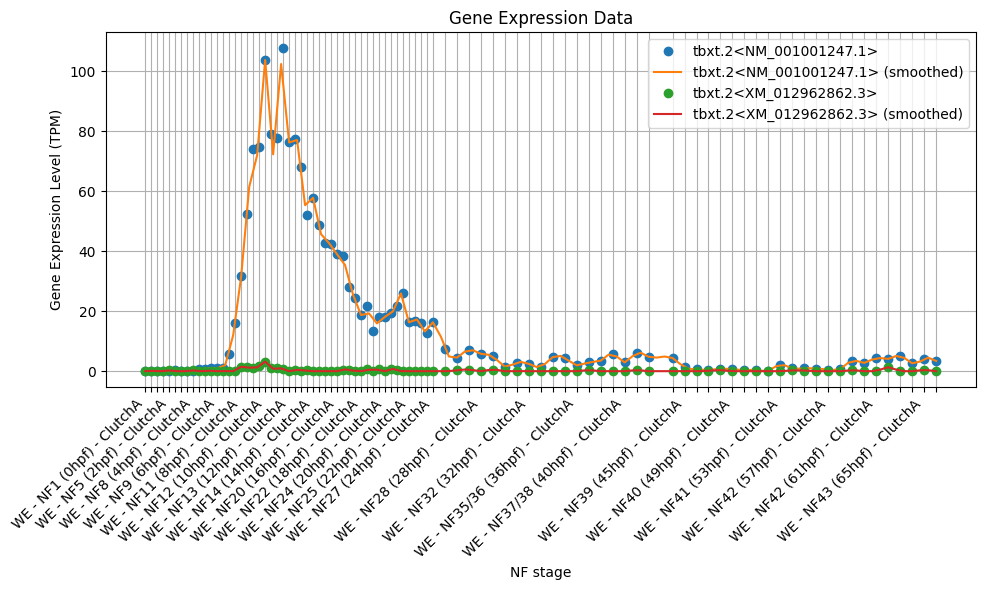

In [9]:
# @title Graph with proper timing
# Load DataFrame
new_tpm_matrix = pd.read_csv('output.txt', sep='\t', index_col=0)
# Given timings
timings = {
	'WE - NF1 (0hpf) - ClutchA': 0,
	'WE - NF1 (0.5hpf) - ClutchA': 0.5,
	'WE - NF2- (1hpf) - ClutchA': 1,
	'WE - NF3 (1.5hpf) - ClutchA': 1.5,
	'WE - NF5 (2hpf) - ClutchA': 2,
	'WE - NF6 (2.5hpf) - ClutchA': 2.5,
	'WE - NF7 (3hpf) - ClutchA': 3,
	'WE - NF7 (3.5hpf) - ClutchA': 3.5 ,
	'WE - NF8 (4hpf) - ClutchA': 4,
	'WE - NF9 (4.5hpf) - ClutchA': 4.5,
	'WE - NF9 (5hpf) - ClutchA': 5,
	'WE - NF9 (5.5hpf) - ClutchA': 5.5,
	'WE - NF9 (6hpf) - ClutchA': 6,
	'WE - NF10 (6.5hpf) - ClutchA': 6.5,
	'WE - NF10 (7hpf) - ClutchA': 7,
	'WE - NF10 (7.5hpf) - ClutchA': 7.5,
	'WE - NF11 (8hpf) - ClutchA': 8,
	'WE - NF12 (8.5hpf) - ClutchA': 8.5,
	'WE - NF12 (9hpf) - ClutchA': 9,
	'WE - NF12 (9.5hpf) - ClutchA': 9.5,
	'WE - NF12 (10hpf) - ClutchA': 10,
	'WE - NF12.5 (10.5hpf) - ClutchA': 10.5,
	'WE - NF12.5 (11hpf) - ClutchA': 11,
	'WE - NF12.5 (11.5hpf) - ClutchA': 11.5,
	'WE - NF13 (12hpf) - ClutchA': 12,
	'WE - NF13 (12.5hpf) - ClutchA': 12.5,
	'WE - NF13 (13hpf) - ClutchA': 13,
	'WE - NF14 (13.5hpf) - ClutchA': 13.5,
	'WE - NF14 (14hpf) - ClutchA': 14,
	'WE - NF15 (14.5hpf) - ClutchA': 14.5,
	'WE - NF16-17 (15hpf) - ClutchA': 15,
	'WE - NF18-19 (15.5hpf) - ClutchA': 15.5,
	'WE - NF20 (16hpf) - ClutchA': 16,
	'WE - NF21 (16.5hpf) - ClutchA': 16.5,
	'WE - NF21 (17hpf) - ClutchA': 17,
	'WE - NF22 (17.5hpf) - ClutchA': 17.5,
	'WE - NF22 (18hpf) - ClutchA': 18,
	'WE - NF23 (18.5hpf) - ClutchA': 18.5,
	'WE - NF24 (19hpf) - ClutchA': 19,
	'WE - NF24 (19.5hpf) - ClutchA': 19.5,
	'WE - NF24 (20hpf) - ClutchA': 20,
	'WE - NF24 (20.5hpf) - ClutchA': 20.5,
	'WE - NF25 (21hpf) - ClutchA': 21,
	'WE - NF25 (21.5hpf) - ClutchA': 21.5,
	'WE - NF25 (22hpf) - ClutchA': 22,
	'WE - NF26 (22.5hpf) - ClutchA': 22.5,
	'WE - NF26 (23hpf) - ClutchA': 23,
	'WE - NF26 (23.5hpf) - ClutchA': 23.5,
	'WE - NF27 (24hpf) - ClutchA': 24,
	'WE - NF27 (25hpf) - ClutchA': 25,
	'WE - NF27 (26hpf) - ClutchA': 26,
	'WE - NF28 (27hpf) - ClutchA': 27,
	'WE - NF28 (28hpf) - ClutchA': 28,
	'WE - NF29/30 (29hpf) - ClutchA': 29,
	'WE - NF31 (30hpf) - ClutchA': 30,
	'WE - NF32 (31hpf) - ClutchA': 31,
	'WE - NF32 (32hpf) - ClutchA': 32,
	'WE - NF33/34 (33hpf) - ClutchA': 33,
	'WE - NF33/34 (34hpf) - ClutchA': 34,
	'WE - NF33/34 (35hpf) - ClutchA': 35,
	'WE - NF35/36 (36hpf) - ClutchA': 36,
	'WE - NF35/36 (37hpf) - ClutchA': 37,
	'WE - NF37/38 (38hpf) - ClutchA': 38,
	'WE - NF37/38 (39hpf) - ClutchA': 39,
	'WE - NF37/38 (40hpf) - ClutchA': 40,
	'WE - NF39 (41hpf) - ClutchA': 41,
	'WE - NF39 (42hpf) - ClutchA': 42,
	'WE - NF39 (44hpf) - ClutchA': 44,
	'WE - NF39 (45hpf) - ClutchA': 45,
	'WE - NF40 (46hpf) - ClutchA': 46,
	'WE - NF40 (47hpf) - ClutchA': 47,
	'WE - NF40 (48hpf) - ClutchA': 48,
	'WE - NF40 (49hpf) - ClutchA': 49,
	'WE - NF40 (50hpf) - ClutchA': 50,
	'WE - NF41 (51hpf) - ClutchA': 51,
	'WE - NF41 (52hpf) - ClutchA': 52,
	'WE - NF41 (53hpf) - ClutchA': 53,
	'WE - NF41 (54hpf) - ClutchA': 54,
	'WE - NF41 (55hpf) - ClutchA': 55,
	'WE - NF42 (56hpf) - ClutchA': 56,
	'WE - NF42 (57hpf) - ClutchA': 57,
	'WE - NF42 (58hpf) - ClutchA': 58,
	'WE - NF42 (59hpf) - ClutchA': 59,
	'WE - NF42 (60hpf) - ClutchA': 60,
	'WE - NF42 (61hpf) - ClutchA': 61,
	'WE - NF42 (62hpf) - ClutchA': 62,
	'WE - NF43 (63hpf) - ClutchA': 63,
	'WE - NF43 (64hpf) - ClutchA': 64,
	'WE - NF43 (65hpf) - ClutchA': 65,
	'WE - NF43 (66hpf) - ClutchA': 66
}

# Create DataFrame
df = pd.DataFrame(new_tpm_matrix)
df = df[['GeneRefSeq', 'WE - NF1 (0hpf) - ClutchA','WE - NF1 (0.5hpf) - ClutchA','WE - NF2- (1hpf) - ClutchA','WE - NF3 (1.5hpf) - ClutchA','WE - NF5 (2hpf) - ClutchA','WE - NF6 (2.5hpf) - ClutchA','WE - NF7 (3hpf) - ClutchA','WE - NF7 (3.5hpf) - ClutchA','WE - NF8 (4hpf) - ClutchA','WE - NF9 (4.5hpf) - ClutchA','WE - NF9 (5hpf) - ClutchA','WE - NF9 (5.5hpf) - ClutchA','WE - NF9 (6hpf) - ClutchA','WE - NF10 (6.5hpf) - ClutchA','WE - NF10 (7hpf) - ClutchA','WE - NF10 (7.5hpf) - ClutchA','WE - NF11 (8hpf) - ClutchA','WE - NF12 (8.5hpf) - ClutchA','WE - NF12 (9hpf) - ClutchA','WE - NF12 (9.5hpf) - ClutchA','WE - NF12 (10hpf) - ClutchA','WE - NF12.5 (10.5hpf) - ClutchA','WE - NF12.5 (11hpf) - ClutchA','WE - NF12.5 (11.5hpf) - ClutchA','WE - NF13 (12hpf) - ClutchA','WE - NF13 (12.5hpf) - ClutchA','WE - NF13 (13hpf) - ClutchA','WE - NF14 (13.5hpf) - ClutchA','WE - NF14 (14hpf) - ClutchA','WE - NF15 (14.5hpf) - ClutchA','WE - NF16-17 (15hpf) - ClutchA','WE - NF18-19 (15.5hpf) - ClutchA','WE - NF20 (16hpf) - ClutchA','WE - NF21 (16.5hpf) - ClutchA','WE - NF21 (17hpf) - ClutchA','WE - NF22 (17.5hpf) - ClutchA','WE - NF22 (18hpf) - ClutchA','WE - NF23 (18.5hpf) - ClutchA','WE - NF24 (19hpf) - ClutchA','WE - NF24 (19.5hpf) - ClutchA','WE - NF24 (20hpf) - ClutchA','WE - NF24 (20.5hpf) - ClutchA','WE - NF25 (21hpf) - ClutchA','WE - NF25 (21.5hpf) - ClutchA','WE - NF25 (22hpf) - ClutchA','WE - NF26 (22.5hpf) - ClutchA','WE - NF26 (23hpf) - ClutchA','WE - NF26 (23.5hpf) - ClutchA','WE - NF27 (24hpf) - ClutchA','WE - NF27 (25hpf) - ClutchA','WE - NF27 (26hpf) - ClutchA','WE - NF28 (27hpf) - ClutchA','WE - NF28 (28hpf) - ClutchA','WE - NF29/30 (29hpf) - ClutchA','WE - NF31 (30hpf) - ClutchA','WE - NF32 (31hpf) - ClutchA','WE - NF32 (32hpf) - ClutchA','WE - NF33/34 (33hpf) - ClutchA','WE - NF33/34 (34hpf) - ClutchA','WE - NF33/34 (35hpf) - ClutchA','WE - NF35/36 (36hpf) - ClutchA','WE - NF35/36 (37hpf) - ClutchA','WE - NF37/38 (38hpf) - ClutchA','WE - NF37/38 (39hpf) - ClutchA','WE - NF37/38 (40hpf) - ClutchA','WE - NF39 (41hpf) - ClutchA','WE - NF39 (42hpf) - ClutchA','WE - NF39 (44hpf) - ClutchA','WE - NF39 (45hpf) - ClutchA','WE - NF40 (46hpf) - ClutchA','WE - NF40 (47hpf) - ClutchA','WE - NF40 (48hpf) - ClutchA','WE - NF40 (49hpf) - ClutchA','WE - NF40 (50hpf) - ClutchA','WE - NF41 (51hpf) - ClutchA','WE - NF41 (52hpf) - ClutchA','WE - NF41 (53hpf) - ClutchA','WE - NF41 (54hpf) - ClutchA','WE - NF41 (55hpf) - ClutchA','WE - NF42 (56hpf) - ClutchA','WE - NF42 (57hpf) - ClutchA','WE - NF42 (58hpf) - ClutchA','WE - NF42 (59hpf) - ClutchA','WE - NF42 (60hpf) - ClutchA','WE - NF42 (61hpf) - ClutchA','WE - NF42 (62hpf) - ClutchA','WE - NF43 (63hpf) - ClutchA','WE - NF43 (64hpf) - ClutchA','WE - NF43 (65hpf) - ClutchA','WE - NF43 (66hpf) - ClutchA']]

# Filter the DataFrame to include only the specified genes
df['Gene'] = df['GeneRefSeq'].str.split('<').str[0]
filtered_df = df[df['Gene'].isin(genes_to_plot)]
filtered_df = filtered_df.drop(columns=['Gene'])

# Plotting
plt.figure(figsize=(10, 6))

for index, row in filtered_df.iterrows():
    gene = row['GeneRefSeq']
    expression_values = row.drop('GeneRefSeq').values
    time_points = row.drop('GeneRefSeq').index

    # Interpolating time points to align with the given timings
    stage_positions = [timings[stage] for stage in time_points]

    # Perform cubic spline interpolation
    f = interp1d(stage_positions, expression_values, kind='cubic')
    x_new = np.linspace(min(stage_positions), max(stage_positions), 100)  # Adjust 100 for desired smoothness
    y_new = np.maximum(f(x_new), 0)

    stage_labels =  ['WE - NF1 (0hpf) - ClutchA','WE - NF1 (0.5hpf) - ClutchA','WE - NF2- (1hpf) - ClutchA','WE - NF3 (1.5hpf) - ClutchA','WE - NF5 (2hpf) - ClutchA','WE - NF6 (2.5hpf) - ClutchA','WE - NF7 (3hpf) - ClutchA','WE - NF7 (3.5hpf) - ClutchA','WE - NF8 (4hpf) - ClutchA','WE - NF9 (4.5hpf) - ClutchA','WE - NF9 (5hpf) - ClutchA','WE - NF9 (5.5hpf) - ClutchA','WE - NF9 (6hpf) - ClutchA','WE - NF10 (6.5hpf) - ClutchA','WE - NF10 (7hpf) - ClutchA','WE - NF10 (7.5hpf) - ClutchA','WE - NF11 (8hpf) - ClutchA','WE - NF12 (8.5hpf) - ClutchA','WE - NF12 (9hpf) - ClutchA','WE - NF12 (9.5hpf) - ClutchA','WE - NF12 (10hpf) - ClutchA','WE - NF12.5 (10.5hpf) - ClutchA','WE - NF12.5 (11hpf) - ClutchA','WE - NF12.5 (11.5hpf) - ClutchA','WE - NF13 (12hpf) - ClutchA','WE - NF13 (12.5hpf) - ClutchA','WE - NF13 (13hpf) - ClutchA','WE - NF14 (13.5hpf) - ClutchA','WE - NF14 (14hpf) - ClutchA','WE - NF15 (14.5hpf) - ClutchA','WE - NF16-17 (15hpf) - ClutchA','WE - NF18-19 (15.5hpf) - ClutchA','WE - NF20 (16hpf) - ClutchA','WE - NF21 (16.5hpf) - ClutchA','WE - NF21 (17hpf) - ClutchA','WE - NF22 (17.5hpf) - ClutchA','WE - NF22 (18hpf) - ClutchA','WE - NF23 (18.5hpf) - ClutchA','WE - NF24 (19hpf) - ClutchA','WE - NF24 (19.5hpf) - ClutchA','WE - NF24 (20hpf) - ClutchA','WE - NF24 (20.5hpf) - ClutchA','WE - NF25 (21hpf) - ClutchA','WE - NF25 (21.5hpf) - ClutchA','WE - NF25 (22hpf) - ClutchA','WE - NF26 (22.5hpf) - ClutchA','WE - NF26 (23hpf) - ClutchA','WE - NF26 (23.5hpf) - ClutchA','WE - NF27 (24hpf) - ClutchA','WE - NF27 (25hpf) - ClutchA','WE - NF27 (26hpf) - ClutchA','WE - NF28 (27hpf) - ClutchA','WE - NF28 (28hpf) - ClutchA','WE - NF29/30 (29hpf) - ClutchA','WE - NF31 (30hpf) - ClutchA','WE - NF32 (31hpf) - ClutchA','WE - NF32 (32hpf) - ClutchA','WE - NF33/34 (33hpf) - ClutchA','WE - NF33/34 (34hpf) - ClutchA','WE - NF33/34 (35hpf) - ClutchA','WE - NF35/36 (36hpf) - ClutchA','WE - NF35/36 (37hpf) - ClutchA','WE - NF37/38 (38hpf) - ClutchA','WE - NF37/38 (39hpf) - ClutchA','WE - NF37/38 (40hpf) - ClutchA','WE - NF39 (41hpf) - ClutchA','WE - NF39 (42hpf) - ClutchA','WE - NF39 (44hpf) - ClutchA','WE - NF39 (45hpf) - ClutchA','WE - NF40 (46hpf) - ClutchA','WE - NF40 (47hpf) - ClutchA','WE - NF40 (48hpf) - ClutchA','WE - NF40 (49hpf) - ClutchA','WE - NF40 (50hpf) - ClutchA','WE - NF41 (51hpf) - ClutchA','WE - NF41 (52hpf) - ClutchA','WE - NF41 (53hpf) - ClutchA','WE - NF41 (54hpf) - ClutchA','WE - NF41 (55hpf) - ClutchA','WE - NF42 (56hpf) - ClutchA','WE - NF42 (57hpf) - ClutchA','WE - NF42 (58hpf) - ClutchA','WE - NF42 (59hpf) - ClutchA','WE - NF42 (60hpf) - ClutchA','WE - NF42 (61hpf) - ClutchA','WE - NF42 (62hpf) - ClutchA','WE - NF43 (63hpf) - ClutchA','WE - NF43 (64hpf) - ClutchA','WE - NF43 (65hpf) - ClutchA','WE - NF43 (66hpf) - ClutchA']

    plt.plot(stage_positions, expression_values, 'o', label=gene)  # Plot original data points
    plt.plot(x_new, y_new, label=f'{gene} (smoothed)')  # Plot smoothed line

# Customize x-axis ticks
tick_positions = range(len(stage_labels))
tick_labels = [stage_labels[i] if i % 4 == 0 else '' for i in range(len(stage_labels))]  # Skip every other label

plt.xlabel('NF stage')  # X-axis represents time in hours
plt.ylabel('Gene Expression Level (TPM)')
plt.title('Gene Expression Data')
plt.xticks(list(timings.values()), tick_labels, rotation=45, ha='right')  # Set custom ticks and labels
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()